In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from quetzal.model import stepmodel


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [3]:
# Load the network model from the last exercise
model_path = '../model/'
input_path = '../input/'
output_path = '../outputs/'
is not os.path.exists(output_path+scenario+'/'):
    os.makedirs(output_path+scenario+'/')

In [4]:
show_plots = manual
scenario = 'car_free'#scenario

# Trip generation, trip distribution, mode choice, and traffic assignment

In [5]:
# Load OD-LoS stack
los = stepmodel.read_zippedpickles(model_path + 'los')

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.90s/it]


In [6]:
# load network
sm = stepmodel.read_json(model_path + 'network')
if not type(sm.zones) == gpd.GeoDataFrame:
    sm.zones = gpd.GeoDataFrame(sm.zones, crs=sm.epsg)
sm.pt_los = los.pt_los
sm.car_los = los.car_los

In [7]:
if not sm.zones.index[0].startswith('zone'):
    sm.zones.index = ['zone_'+i for i in sm.zones.index]

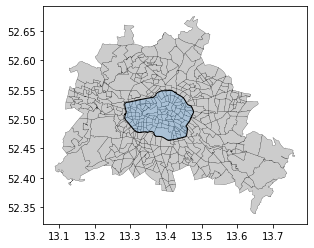

In [8]:
# area within the S-Bahn-Ring
umweltzone = gpd.read_file(input_path + "zone_shapes/Umweltzone_-_Berlin")
umweltzone = umweltzone.to_crs(epsg=sm.epsg)
umweltzone_geom = umweltzone['geometry'].iloc[0]
if show_plots:
    umweltzone.plot(color="#2299ff33", edgecolor="black", linewidth=1, ax=sm.zones.plot(
        color="#cccccc", edgecolor="black", linewidth=0.2))

# Scenario settings

In [9]:
# Define the demand segments (population groups)
sm.segments = ['car', 'no_car', 'pt_abo_car', 'pt_abo_no_car']

In [10]:
# Assumptions about car ownership (default to real data in zones)
sm.zones['car_ownership'] = (sm.zones['privateCarOwnership'] / sm.zones['pop']).clip(upper=1)

In [11]:
# Assumption about PT subscriptions
# More within the ring than outside
within_zones = sm.zones.loc[sm.zones['geometry'].within(umweltzone_geom.buffer(1e-2))].index
sm.zones['pt_subscriptions'] = 600000 / sm.zones['pop'].sum()
sm.zones.loc[within_zones, 'pt_subscriptions'] += 0.05

In [12]:
# PT prices
# Assume day tickets for non-abonnements to be a single ticket
# Users with PT subscriptions usually perceive a fraction of the monthly price
#  assume 3 trips a day
for seg in sm.segments:
    if not 'pt_abo' in seg:
        sm.pt_los['price_'+seg] = 2.5
    else:
        sm.pt_los['price_'+seg] = 49 / 30 / 3
    sm.pt_los.loc[sm.pt_los['all_walk'], 'price_'+seg] = 0

In [13]:
# Individual modes
# Car usage has operating cost of 14ct/km in average
# Note: we don't apply sunk cost like maintenance or purchase cost
for seg in sm.segments:
    if not 'no_car' in seg:
        sm.car_los['price_'+seg] = sm.car_los['length'] * 0.14 / 1000
    else:
        # cap price
        cap_price_base = 3.9
        cap_price_short_km = 2.3
        cap_price_long_km = 1.65
        cap_threshold_long = 7000
        sm.car_los['price_'+seg] = cap_price_base
        sm.car_los.loc[sm.car_los['length']<=cap_threshold_long, 'price_'+seg] += \
            sm.car_los.loc[sm.car_los['length']<=cap_threshold_long, 'length'] * cap_price_short_km / 1000
        sm.car_los.loc[sm.car_los['length']>cap_threshold_long, 'price_'+seg] += \
            sm.car_los.loc[sm.car_los['length']>cap_threshold_long, 'length'] * cap_price_long_km / 1000
        
    # Cycling is free
    sm.car_los.loc[sm.car_los['route_type']=='bike', 'price_'+seg] = 0

In [14]:
# Parking time (based on parking availability)
sm.car_los.loc[sm.car_los['route_type']=='car', 'time'] += 5*60

In [15]:
# Car-free ring
car_free = scenario == 'car_free'
if car_free:
    # Make car trips to the ring the price of taxi trips
    mask = (sm.car_los['origin'].isin(within_zones) | sm.car_los['destination'].isin(within_zones)
           ) & sm.car_los['route_type']=='car'
    for seg in sm.segments:
        sm.car_los.loc[mask, 'price_'+seg] = sm.car_los.loc[mask, 'price_no_car']

# Trip generation

Simulate the number of trips.

In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.

In [16]:
# Load data
age = pd.read_excel(input_path + 'zone_stats/sbb_plr_alter5Jahre.xlsx', index_col=0)
age_sex = pd.read_excel(input_path + 'zone_stats/sbb_plr_alter5Jahre_geschlecht.xlsx', header=[0,1], index_col=0)
age_groups = list(age.columns)
genders = [x[1] for x in age_sex.columns][:2]
age_gender_groups = [item for sublist in [[(age_group, gender) for gender in genders]
                                          for age_group in age_groups]
                     for item in sublist]
# recode to percentage of zone population
age_sex[age_gender_groups] = age_sex[age_gender_groups].replace('-', 0)
age_gender_totals = [age_sex.iloc[n][age_gender_groups].sum() for n in range(len(age_sex))]
# set as percentage
age_sex[age_gender_groups] = [age_sex.iloc[n][age_gender_groups]/age_gender_totals[n] for n in range(len(age_sex))]

anzahl_wege_alter15 = pd.read_excel(input_path + 'transport_stats/anzahl_wege_alter15.xlsx', index_col=0)
anzahl_wege_alter15['age_groups'] = [[] for x in range(len(anzahl_wege_alter15))]
anzahl_wege_alter15['age_groups'].iloc[0] = age_groups[0:3]
anzahl_wege_alter15['age_groups'].iloc[1] = age_groups[3:5]
anzahl_wege_alter15['age_groups'].iloc[2] = age_groups[5:9]
anzahl_wege_alter15['age_groups'].iloc[3] = age_groups[9:13]
anzahl_wege_alter15['age_groups'].iloc[4] = age_groups[13:]

alter_geschlecht_wegzweck = pd.read_excel(input_path + 'transport_stats/alter_geschlecht_wegzweck.xlsx',
                                          header=[0,1], index_col = 0)

wege_zweck_poiskeys = pd.read_excel(input_path + 'transport_stats/wege_zweck_poiskeys.xlsx', index_col=0)[:11]

# create dictonary to look up age x gender groups and there respective number of daily trips
age_gender_dict = dict([(x,dict([(g,[]) for g in genders])) for x in age_groups])
age_10_groups =  [x[0] for x in alter_geschlecht_wegzweck.columns]
for n, age_group in enumerate(age_groups):
    age_group_ind = [n for n, x in enumerate(list(anzahl_wege_alter15['age_groups'])) if age_group in x][0]
    age_gender_dict[age_group]['age_10_group']  = age_10_groups[n] if n < len(age_10_groups) else age_10_groups[-1]
    for gender in genders:
        age_gender_dict[age_group][gender] = anzahl_wege_alter15[gender].iloc[age_group_ind]

strecke_wegzweck = pd.read_excel(input_path + 'transport_stats/strecke_wegzwecke_mid17_t9.xlsx', index_col = 0)

modalsplit_prozent_wege_berlin = pd.read_excel(input_path + 'transport_stats/modalsplit_prozent_wege_berlin.xlsx', index_col=0)
modalsplit_prozent_wege_berlin = modalsplit_prozent_wege_berlin[['Alle Wege']]/100

trip_purposes = strecke_wegzweck.index.values

In [17]:
# Detailed generation by trip purpose
sm.zones['total_emissions'] = 0
sm.zones['total_attractions'] = 0

zones_list = [int(i.split('_')[1]) for i in sm.zones.index]
age_sex_index_dict = dict([(x, list(age_sex.index).index(x)) for x in zones_list])
emission_list, attraction_list, _factors = [], [], []
for trip_purpose in trip_purposes:
    # create emission per trip_purpose per zone
    purpose_age_gender = alter_geschlecht_wegzweck[alter_geschlecht_wegzweck.index == trip_purpose].iloc[0]
    emission_clmn = 'em_'+trip_purpose
    emission_list.append(\
        [\
            sm.zones.loc[i]['pop'] * \
            sum(\
                [sum([age_sex.iloc[age_sex_index_dict[bd]][(age_group,gender)]*age_gender_dict[age_group][gender] * \
                purpose_age_gender[(age_gender_dict[age_group]['age_10_group'], gender)]/100 for gender in genders]) \
                for age_group in age_groups]\
            ) \
        for i, bd in zip(sm.zones.index.values, zones_list)])
    
    sm_zones_emission_clmn = emission_list[-1]
    
    # create attraction per trip_purpose per zone
    attraction_clmn = 'at_'+trip_purpose
    
    sm_zones_attraction_clmn = [0 for x in sm_zones_emission_clmn]
    
    if trip_purpose in ['Work', 'Business']: # only work or business and work? 
        sm_zones_attraction_clmn = sm.zones['emp']
    else:
        purpose_arr = ['Education', 'Accompaniment', 'Leisure'] if trip_purpose=='Accompaniment' else [trip_purpose]
        if any([x in purpose_arr for x in ['Education', 'Accompaniment']]):
            purpose_arr.append('Education;Accompaniment')

        purpose_mult = .2 if trip_purpose=='Accompaniment' else .8 if  trip_purpose=='Education' else .8 if  trip_purpose=='Leisure' else 1

        poi_purposes = wege_zweck_poiskeys.index.values[[z in purpose_arr for z in wege_zweck_poiskeys['Wegzweck']]]
        
        for poi_purpose in poi_purposes:
            if poi_purpose in sm.zones.columns:        
                sm_zones_attraction_clmn += sm.zones[poi_purpose] * purpose_mult
            else: print("poi_purpose not found:", poi_purpose)
    
    # make sure total attraction equal total emission
    _factor = sum(sm_zones_emission_clmn)/sum(sm_zones_attraction_clmn)
    _factors.append(_factor)
    sm_zones_attraction_clmn = sm_zones_attraction_clmn * _factor

    attraction_list.append(sm_zones_attraction_clmn)

    # correct for more trips carried out by car owners
    for seg in sm.segments:
        if not 'no_car' in seg:
            if 'pt_abo' in seg:
                sm.zones[(seg, emission_clmn)] = [e*o*pt*1.05 for e,o,pt in zip(
                    sm_zones_emission_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
                sm.zones[(seg, attraction_clmn)] = [a*o*pt*1.05 for a,o,pt in zip(
                    sm_zones_attraction_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
            else:
                sm.zones[(seg, emission_clmn)] = [e*o*(1-pt)*1.05 for e,o,pt in zip(
                    sm_zones_emission_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
                sm.zones[(seg, attraction_clmn)] = [a*o*(1-pt)*1.05 for a,o,pt in zip(
                    sm_zones_attraction_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
        else:
            if 'pt_abo' in seg:
                sm.zones[(seg, emission_clmn)] = [e*(1-o)*pt/1.04 for e,o,pt in zip(
                    sm_zones_emission_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
                sm.zones[(seg, attraction_clmn)] = [a*(1-o)*pt/1.04 for a,o,pt in zip(
                    sm_zones_attraction_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
            else:
                sm.zones[(seg, emission_clmn)] = [e*(1-o)*(1-pt)/1.04 for e,o,pt in zip(
                    sm_zones_emission_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
                sm.zones[(seg, attraction_clmn)] = [a*(1-o)*(1-pt)/1.04 for a,o,pt in zip(
                    sm_zones_attraction_clmn, sm.zones['car_ownership'], sm.zones['pt_subscriptions'])]
        sm.zones[(seg, emission_clmn)] = sm.zones[(seg, emission_clmn)].astype(int)
        sm.zones[(seg, attraction_clmn)] = sm.zones[(seg, attraction_clmn)].astype(int)

    sm.zones['total_emissions'] += sm_zones_emission_clmn
    sm.zones['total_attractions'] += sm_zones_attraction_clmn
    
    print(trip_purpose, _factor)

Work 1.3660409852623798
Business 0.8780068143325598
Education 1.4111048480891506
Shopping 1.5089482120621367
Errands 2.807861344128043
poi_purpose not found: Own apartment
Leisure 2.85146262868293
poi_purpose not found: Own apartment
Accompaniment 2.357349387270517


In [18]:
sm.zones.sample()

BEZIRKSNAM   PLANUNGSRA  FLAECHENGR    pop  \
zone_09010101  Treptow-Köpenick  Elsenstraße  1234438.18  13050   

               popCentroidLat  popCentroidLon          emp  pois  \
zone_09010101       52.490342       13.449641  9504.904083   146   

               poiCentroidLat  poiCentroidLon  ...  \
zone_09010101       52.491226        13.45185  ...   

               (pt_abo_no_car, em_Leisure)  (pt_abo_no_car, at_Leisure)  \
zone_09010101                         1930                         1706   

               (car, em_Accompaniment)  (car, at_Accompaniment)  \
zone_09010101                      790                      568   

               (no_car, em_Accompaniment)  (no_car, at_Accompaniment)  \
zone_09010101                        2789                        2005   

               (pt_abo_car, em_Accompaniment)  (pt_abo_car, at_Accompaniment)  \
zone_09010101                             208                             150   

              (pt_abo_no_car, em_Accompaniment)  \
zone_09010101                               736   

               (pt_abo_no_car, at_Accompaniment)  
zone_09010101                                529  

[1 rows x 79 columns]

# Trip distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed here) requires to change emission and attraction values or the impedance matrix

In [19]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los.loc[sm.car_los['route_type']=='car', ['origin', 'destination', 'time']
                               ].drop_duplicates().set_index(['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
stay = min(60*3, car_imp_matrix.min().min())
car_imp_matrix = car_imp_matrix.replace(0, stay)
car_imp_matrix = car_imp_matrix.fillna(stay)
car_imp_matrix.head(2)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    180.000000    815.849541    611.830100    729.925366   
zone_01011102    816.921682    180.000000    881.143988   1007.400824   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    667.344833    779.879976    943.101738    851.995437   
zone_01011102    936.164081   1017.616541   1118.120807   1085.093763   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101    913.260496    852.332333  ...   1917.174418   2125.981481   
zone_01011102   1153.770455   1015.840623  ...   1971.908289   2180.618570   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   1687.755483   1999.996128   1974.858446   1872.934764   
zone_01011102   1742.392573   2054.633217   2029.495535   1927.571853   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   1821.435589   1979.386239   1574.441188   1720.385525  
zone_01011102   1876.072678   2034.023328   1643.312841   1789.257178  

[2 rows x 448 columns]

In [20]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

pt_imp_matrix = pt_imp_matrix.replace(0, stay)
pt_imp_matrix = pt_imp_matrix.fillna(stay)
pt_imp_matrix.head(2)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    180.000000    943.086069    775.550196    889.299443   
zone_01011102    948.065573    180.000000   1178.455327   1292.204575   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    722.024697    906.533664   1159.375271   1202.188650   
zone_01011102   1151.567193   1024.785846    908.280137   1064.135687   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101   1338.012923   1241.470476  ...   2091.023261   2605.207902   
zone_01011102   1227.900065    990.375341  ...   1839.928127   2354.112768   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   2252.230544   2359.578794   2394.773154   2485.570120   
zone_01011102   1989.777086   2097.125335   2132.319696   2223.116661   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   2199.728971   2266.905747   2287.158878   2615.308035  
zone_01011102   1948.633836   2015.810613   2005.250441   2333.399598  

[2 rows x 448 columns]

### use different weighting of impedance matrix for different trip purposes 
(e.g. stronger decay over distance for shopping than for work)

#### set deterance parameter depending on average distance per trip purpose

In [21]:
# make deterence matrix parameters depndent on average trip length
mult_shift = \
    dict([\
            (trip_purpose, dict([\
                ('km', strecke_wegzweck['km'].loc[trip_purpose]), \
                ('_mult', 1/ (8000.0*1.0 + 0.01 * 1000 * strecke_wegzweck['km'].loc[trip_purpose]) ), \
                ('_exp',2), \
                ('_shift',0.0)\
            ]))\
    for trip_purpose in trip_purposes])
mult_shift

{'Work': {'km': 12, '_mult': 0.0001231527093596059, '_exp': 2, '_shift': 0.0},
 'Business': {'km': 18,
  '_mult': 0.00012224938875305622,
  '_exp': 2,
  '_shift': 0.0},
 'Education': {'km': 7,
  '_mult': 0.00012391573729863693,
  '_exp': 2,
  '_shift': 0.0},
 'Shopping': {'km': 5,
  '_mult': 0.00012422360248447205,
  '_exp': 2,
  '_shift': 0.0},
 'Errands': {'km': 10,
  '_mult': 0.0001234567901234568,
  '_exp': 2,
  '_shift': 0.0},
 'Leisure': {'km': 15,
  '_mult': 0.0001226993865030675,
  '_exp': 2,
  '_shift': 0.0},
 'Accompaniment': {'km': 8,
  '_mult': 0.00012376237623762376,
  '_exp': 2,
  '_shift': 0.0}}

Work
car
no_car
pt_abo_car
pt_abo_no_car
Business
car
no_car
pt_abo_car
pt_abo_no_car
Education
car
no_car
pt_abo_car
pt_abo_no_car
Shopping
car
no_car
pt_abo_car
pt_abo_no_car
Errands
car
no_car
pt_abo_car
pt_abo_no_car
Leisure
car
no_car
pt_abo_car
pt_abo_no_car
Accompaniment
car
no_car
pt_abo_car
pt_abo_no_car


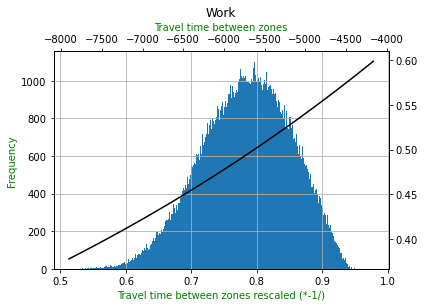

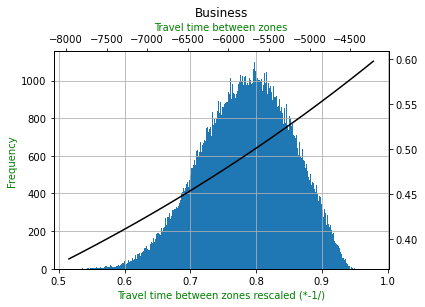

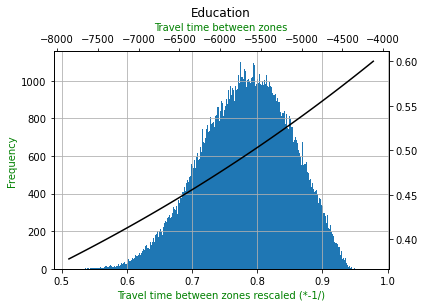

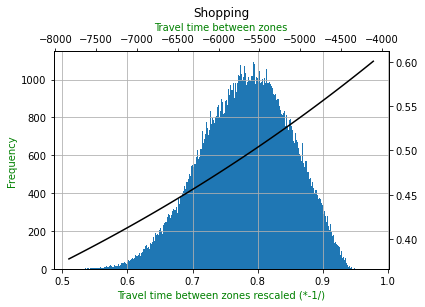

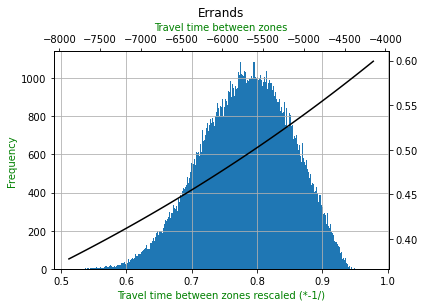

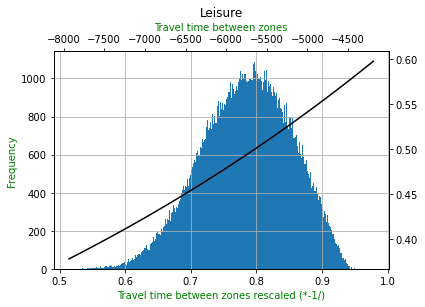

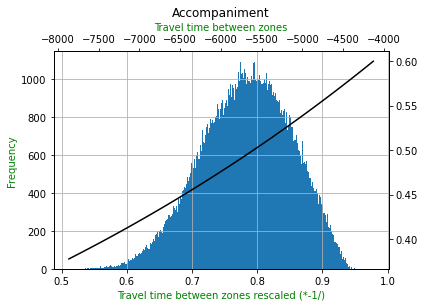

In [22]:
od_volumes = {}

for trip_purpose in trip_purposes:
    print(trip_purpose)
    car_imp_matrix_inv = np.exp(car_imp_matrix*-1*mult_shift[trip_purpose]['_mult']+mult_shift[trip_purpose]['_shift'])
    pt_imp_matrix_inv = np.exp(pt_imp_matrix*-1*mult_shift[trip_purpose]['_mult']+mult_shift[trip_purpose]['_shift'])

    deterrence_matrix = {'car': car_imp_matrix_inv,
                         'no_car': pt_imp_matrix_inv,
                         'pt_abo_car': pt_imp_matrix_inv,
                         'pt_abo_no_car': pt_imp_matrix_inv}
    distr_params = {'od_volume_from_zones_kwargs':
                    {'power': {seg:mult_shift[trip_purpose]['_exp'] for seg in sm.segments},
                     'intrazonal':True}}
    
    for seg in sm.segments:
        sm.zones[(seg, 'emission')] = sm.zones[(seg, 'em_'+str(trip_purpose))]
        sm.zones[(seg, 'attraction')] = sm.zones[(seg, 'at_'+str(trip_purpose))]

    sm.step_distribution(segmented=True, deterrence_matrix=deterrence_matrix, **distr_params)
    
    od_volumes[trip_purpose] = sm.volumes

    if show_plots:
        fric_vals = pd.DataFrame({'0': np.asarray([item for sublist in [list(car_imp_matrix_inv.iloc[n])
                                                                        for n in range(len(car_imp_matrix))]
                                                   for item in sublist])})
        ax = fric_vals.hist(bins=500)
        ax1 = ax.flat[0]
        ax2 = ax1.twinx().twiny()

        xs = [x+fric_vals.min()[0] for x in np.array(range(100))*((fric_vals.max()-fric_vals.min())/100)[0]]
        ys = [np.exp(-x) for x in xs]
        xs_recoded = [(x-1*mult_shift[trip_purpose]['_shift'])/mult_shift[trip_purpose]['_mult']*-1 for x in xs]#[::-1]

        ax2.plot(xs_recoded, ys, 'k')
        # ax2.set_title('X')
        ax1.set_title(trip_purpose)

        ax2.set_ylabel('Deterrence parameter', color='b')
        ax1.set_ylabel('Frequency', color='g')
        ax2.set_xlabel('Travel time between zones', color='g')
        ax1.set_xlabel('Travel time between zones rescaled (*-1/'+str()+')', color='g')

In [23]:
# sum all OD matrixes of different trip purposes
od_total_volume = None
for trip_purpose in trip_purposes:
    if not type(od_total_volume) == pd.DataFrame:
        od_total_volume = od_volumes[trip_purpose]
    else:
        od_total_volume[sm.segments+['all']] += od_volumes[trip_purpose][sm.segments+['all']]
sm.volumes = od_total_volume
sm.volumes.sample()

origin    destination       car    no_car  pt_abo_car  \
56312  zone_04030519  zone_08041035  6.314058  6.139409      1.4318   

       pt_abo_no_car        all  
56312       1.363377  15.248645

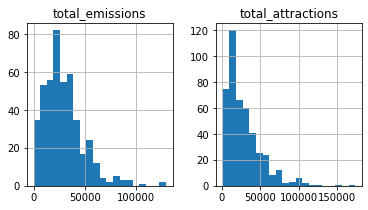

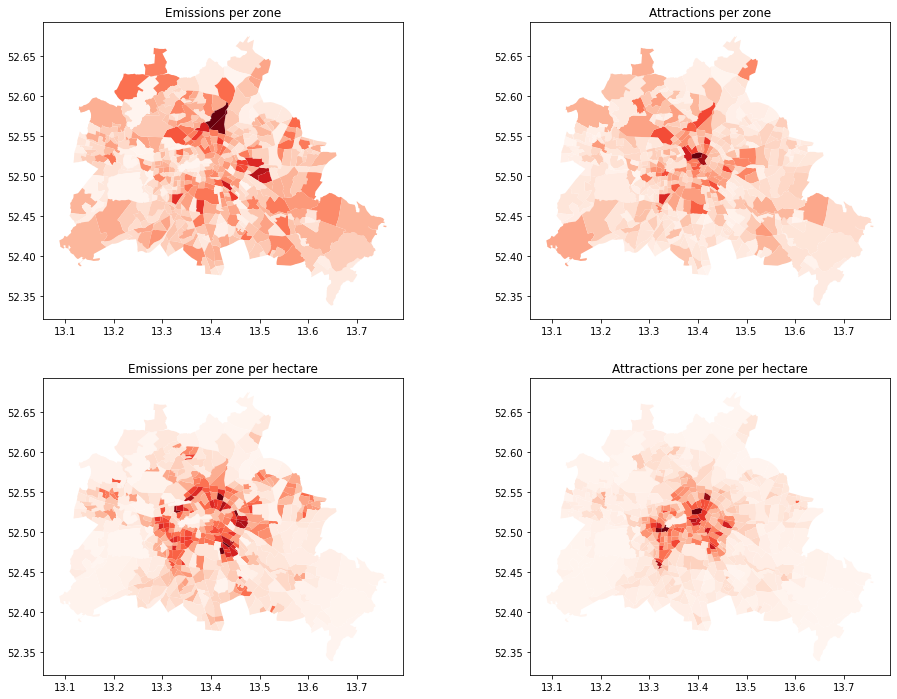

In [24]:
if show_plots:
    sm.zones[['total_emissions', 'total_attractions']].hist(bins=20, figsize=(6,3))
    fig, ax = plt.subplots(2, 2, figsize=(16,12))
    sm.zones.plot(ax=ax.flat[0], column='total_emissions', cmap="Reds")
    ax.flat[0].set_title("Emissions per zone")
    sm.zones.plot(ax=ax.flat[1], column='total_attractions', cmap="Reds")
    ax.flat[1].set_title("Attractions per zone")
    sm.zones.plot(ax=ax.flat[2], cmap="Reds", column=np.array([a/g.area for a,g in zip(sm.zones['total_emissions'].values, sm.zones['geometry'].values) ]))
    ax.flat[2].set_title("Emissions per zone per hectare")
    sm.zones.plot(ax=ax.flat[3], cmap="Reds", column=np.array([a/g.area for a,g in zip(sm.zones['total_attractions'].values, sm.zones['geometry'].values) ]))
    ax.flat[3].set_title("Attractions per zone per hectare")

    plt.savefig(output_path+scenario+'/od_zones'+'_dpi300.png', dpi=300)

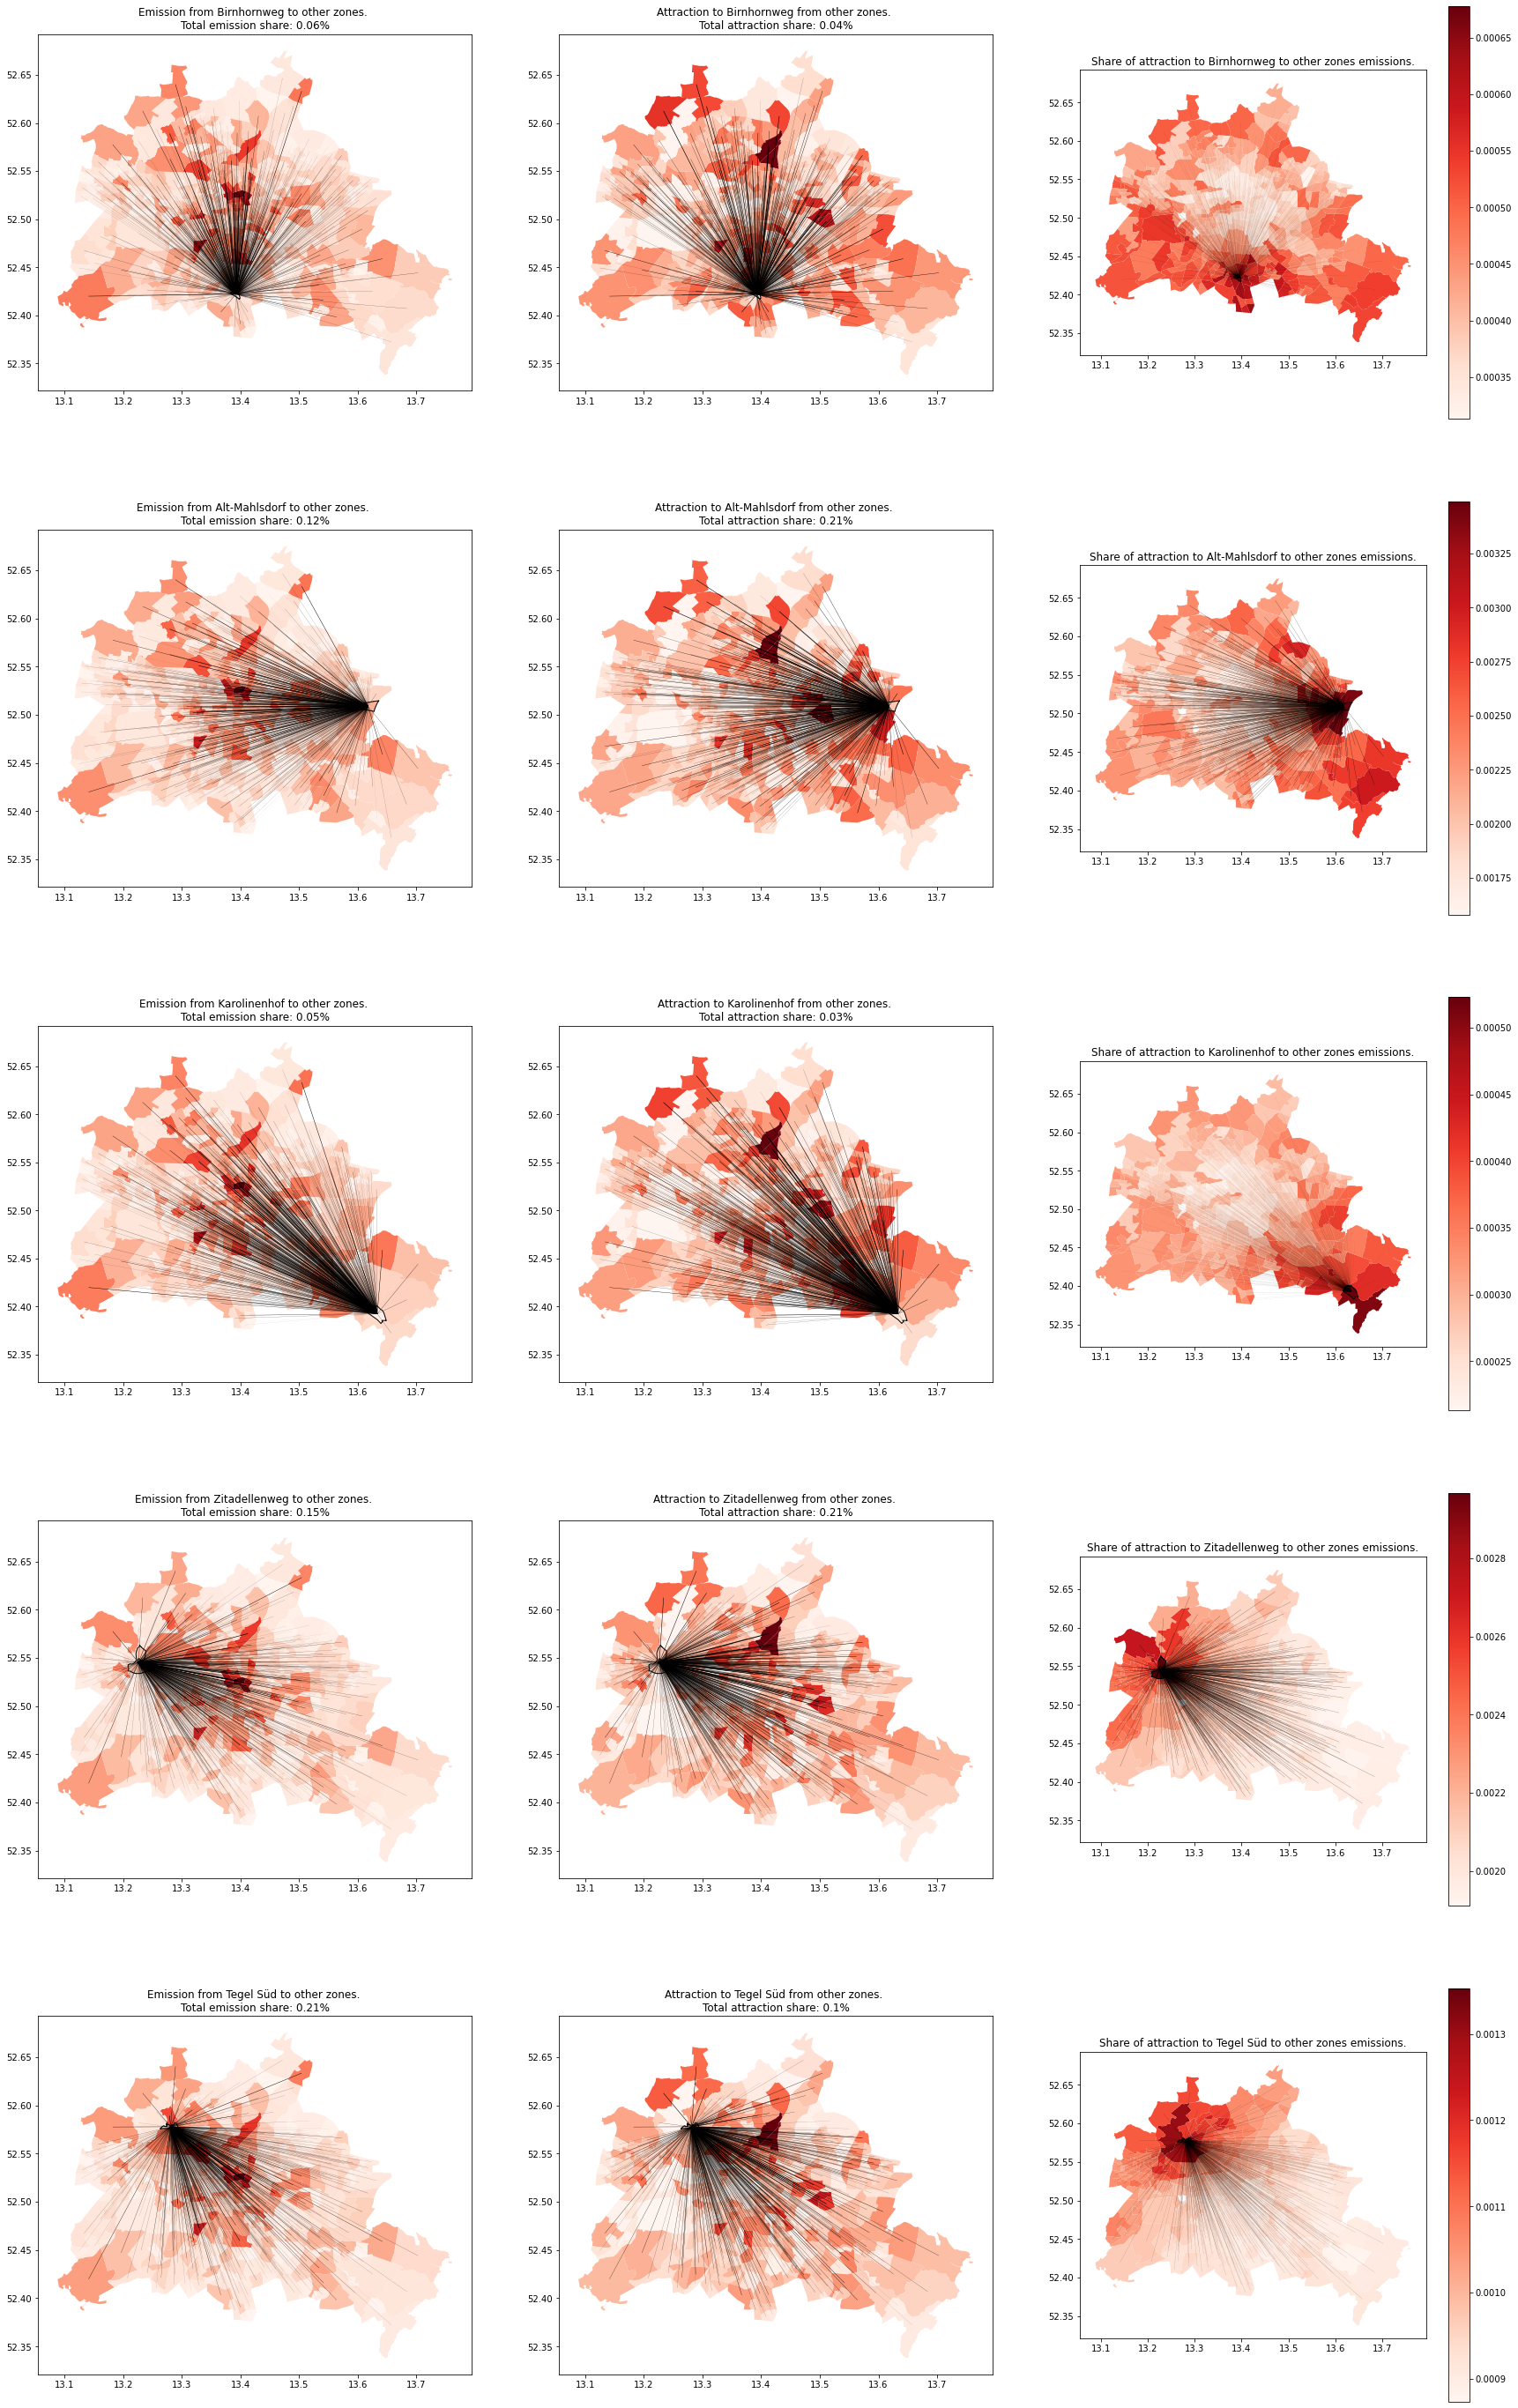

In [25]:
# plots sind sehr zeitaufwändig

if False:
    N = 5
    fig, ax = plt.subplots(nrows=N, ncols=3, figsize=(30,10*N))
    for (n, ind) in enumerate(np.random.permutation(len(sm.zones))[:N]):
        z_id = sm.zones.index[ind]
        
        z_emission = sm.volumes[['destination', 'all']][sm.volumes['origin']==z_id]
        z_attraction = sm.volumes[['origin', 'all']][sm.volumes['destination']==z_id]
        z_emission_from = np.array([item for sublist in [z_emission['all'][z_emission['destination']==i] for i in sm.zones.index] for item in sublist])
        z_attraction_to = np.array([item for sublist in [z_attraction['all'][z_attraction['origin']==i] for i in sm.zones.index] for item in sublist])

        all_emissions = np.array([sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        all_attractions = np.array([sum(sm.volumes['all'][sm.volumes['destination']==i]) for i in sm.zones.index])
        z_attractions = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].sum() for i in sm.zones.index])
        # z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].iloc[0]/sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].sum() / \
            sm.volumes['all'][sm.volumes['origin']==i].sum() for i in sm.zones.index])

        sm.zones.plot(ax=ax.flat[n*3], cmap="Reds", \
            column=z_emission_from)
        sm.zones.plot(ax=ax.flat[n*3+1], cmap="Reds", \
            column=z_attraction_to)
        sm.zones.plot(ax=ax.flat[n*3+2], cmap="Reds", \
            column=z_attraction_share, legend=True)
        
        z_centroid_coords = sm.zones['geometry'].loc[z_id].centroid.coords[0]
        lines = sm.zones.geometry.apply(lambda g: LineString([z_centroid_coords, g.centroid.centroid.coords[0]]))
        
        lines.plot(ax=ax.flat[n*3], color="black", linewidth=z_emission_from/z_emission_from.max())
        lines.plot(ax=ax.flat[n*3+1], color="black", linewidth=z_attraction_to/z_attraction_to.max())
        lines.plot(ax=ax.flat[n*3+2], color="black", linewidth=z_attraction_share/(all_attractions.max()/sum(all_attractions))*1)
        
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+1], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+2], color="None", edgecolor='black', linewidth=1)

        ax.flat[n*3].set_title('Emission from '+ str(sm.zones.loc[z_id]['PLANUNGSRA']) + ' to other zones. \nTotal emission share: ' + str(round(100*z_emission_from.sum()/sum(all_attractions),2)) +'%')
        ax.flat[n*3+1].set_title('Attraction to '+ str(sm.zones.loc[z_id]['PLANUNGSRA']) + ' from other zones. \nTotal attraction share: ' + str(round(100*z_attraction_to.sum()/sum(all_emissions),2))+'%')
        ax.flat[n*3+2].set_title('Share of attraction to '+ str(sm.zones.loc[z_id]['PLANUNGSRA']) + ' to other zones emissions.')

        plt.savefig(output_path+scenario/+'/od_zone_inspection_'+str(N)+'_dpi300.png', dpi=300)
        plt.savefig(output_path+scenario/+'plots/od_zone_inspection_'+str(N)+'_dpi600.png', dpi=600)  

# Mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [26]:
# Combine LoS tables and add walking paths
sm.car_los['ntransfers'] = 0
sm.pt_los.loc[sm.pt_los['route_type']!='walk', 'route_type'] = 'PT'
sm.walk_los = sm.car_los.loc[sm.car_los['route_type']=='bike'].copy()
sm.walk_los['time'] = sm.walk_los['length'] / 6 / 1000 * 3600
sm.walk_los['route_type'] = 'walk'
sm.walk_los['route_types'] = [('walk',) for _ in range(len(sm.walk_los))]
sm.los = pd.concat([sm.pt_los, sm.car_los, sm.walk_los]).reset_index(drop=True)

Every trip has these attributes:
* travel time (TT = sum of different time factors)
* travel costs (TC, see above)
* number of transfers

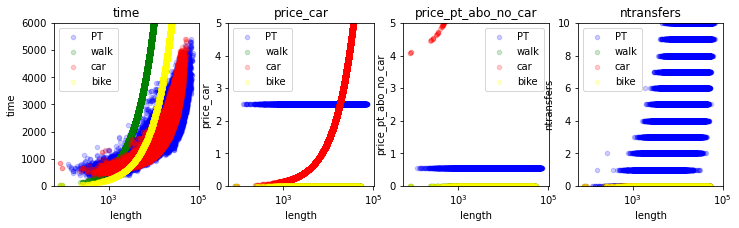

In [27]:
# decision attributes
if show_plots:
    cols = ['time', 'price_car', 'price_pt_abo_no_car', 'ntransfers']
    fig, ax = plt.subplots(nrows=1, ncols=len(cols), figsize=(len(cols)*3, 3))
    for col, i, lim in zip(cols, range(len(cols)), [6e3, 5, 5, 10]):
        try:
            colors = {'PT': 'blue', 'car': 'red', 'bike': 'yellow', 'walk': 'green'}
            for mode in sm.los['route_type'].unique():
                sm.los.loc[sm.los['route_type']==mode].plot.scatter(
                    x='length', y=col, c=colors[mode], alpha=.2, label=mode,
                    ax=ax[i], legend=True, logx=True, ylim=(0,lim))
            ax[i].set_title(col)
        except:
            pass

In [28]:
# Nesting structure
modes = ['walk', 'PT', 'bike', 'car', 'root']
col = ['root'] * (len(modes)-1) + [np.nan]
nests = pd.DataFrame(index=modes, data={s: col for s in sm.segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment      car no_car pt_abo_car pt_abo_no_car
route_type                                      
walk        root   root       root          root
PT          root   root       root          root
bike        root   root       root          root
car         root   root       root          root
root         NaN    NaN        NaN           NaN

In [29]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=modes, data={seg: 1 for seg in sm.segments})
sm.logit_scales.loc['root'] = [1 for i in range(len(sm.segments))]
sm.logit_scales

car  no_car  pt_abo_car  pt_abo_no_car
walk    1       1           1              1
PT      1       1           1              1
bike    1       1           1              1
car     1       1           1              1
root    1       1           1              1

ASC:
* Die ASC repräsentiert den Einfluss unabhängiger Variablen, die auf alle Alternativen gleichermaßen wirken, jedoch nicht durch die anderen Parameter des Modells erfasst werden. 

In [30]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility = pd.DataFrame(index=modes[:-1], columns=sm.segments)
sm.mode_utility.loc['car'] = [5, -50, 5, -50]
sm.mode_utility.loc['bike'] = [-4, -5, -4, -4]
sm.mode_utility.loc['walk'] = [5, 10, 5, 5]
sm.mode_utility.loc['PT'] = [-2, 0, 0, 0]
sm.mode_utility

car no_car pt_abo_car pt_abo_no_car
walk   5     10          5             5
PT    -2      0          0             0
bike  -4     -5         -4            -4
car    5    -50          5           -50

In [31]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
sm.utility_values = pd.DataFrame(index=['price_'+s for s in sm.segments])
sm.utility_values['car'] = [-0.2 for s in range(len(sm.utility_values))]
sm.utility_values['no_car'] = [-0.2 for s in range(len(sm.utility_values))]
sm.utility_values['pt_abo_car'] = [-0.2 for s in range(len(sm.utility_values))]
sm.utility_values['pt_abo_no_car'] = [-0.2 for s in range(len(sm.utility_values))]
sm.utility_values.loc['time'] = [-0.3/60, -0.3/60, -0.3/60, -0.3/60]
sm.utility_values.loc['ntransfers'] = [-2.1, -0.9, -0.9, -1.1]
sm.utility_values.loc['mode_utility'] = 1
sm.utility_values

car  no_car  pt_abo_car  pt_abo_no_car
price_car           -0.200  -0.200      -0.200         -0.200
price_no_car        -0.200  -0.200      -0.200         -0.200
price_pt_abo_car    -0.200  -0.200      -0.200         -0.200
price_pt_abo_no_car -0.200  -0.200      -0.200         -0.200
time                -0.005  -0.005      -0.005         -0.005
ntransfers          -2.100  -0.900      -0.900         -1.100
mode_utility         1.000   1.000       1.000          1.000

In [32]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


In [33]:
# Finally, run the logit model
sm.step_logit() # performes the nested-logic:  prob(mode k)= exp(utility mode k)/sum(utilities, all modes)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.24s/it]


In [34]:
sm.probabilities.sample(2)

route_type         origin    destination        segment  root           car  \
23526       zone_04051448  zone_03020203     pt_abo_car     1  9.016597e-01   
58955       zone_09041401  zone_12231102  pt_abo_no_car     1  1.771613e-32   

route_type          bike        PT          walk  
23526       6.144828e-02  0.036892  1.471756e-11  
58955       3.030489e-12  1.000000  2.037152e-42

In [35]:
sm.utilities.sample()

route_type         origin    destination segment      root        car  \
18397       zone_04030725  zone_04030623  no_car  2.384425 -58.210834   

route_type     bike        PT      walk  
18397      -8.04627 -7.186336  2.384326

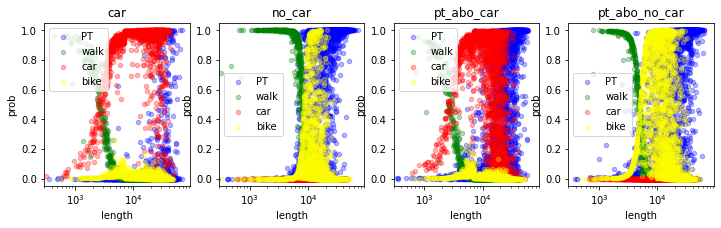

In [36]:
# Probability distribution across modes in different segments
if show_plots:
    fig, ax = plt.subplots(nrows=1, ncols=len(sm.segments), figsize=(3*len(sm.segments), 3), sharex='all')
    for seg, i in zip(sm.segments, range(len(sm.segments))):
        los = sm.los[['route_type', (seg, 'probability'), 'length']].copy()
        los.rename(columns={(seg, 'probability'): 'prob'}, inplace=True)
        #los.groupby('route_type')['prob'].mean().plot.pie(ylabel=seg, ax=ax[i])
        colors = {'PT': 'blue', 'car': 'red', 'bike': 'yellow', 'walk': 'green'}
        colors.update({mode: 'blue' for mode in sm.links['route_type'].unique()})
        for mode in los['route_type'].unique():
            los.loc[los['route_type']==mode].sample(min(len(los.loc[los['route_type']==mode]), int(3e3))).plot.scatter(
                x='length', y='prob', c=colors[mode], alpha=.3, label=mode, logx=True, ax=ax[i], legend=True)
        ax[i].set_title(seg)

## Mode shares

In [37]:
# Compute volumes in path stack
sm.compute_los_volume(time_expanded=False, keep_segments=True)

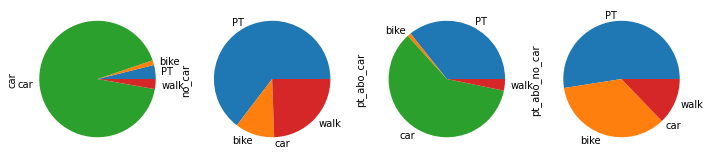

In [38]:
# Modal split (trips) in segments
if show_plots:
    fig, ax = plt.subplots(nrows=1, ncols=len(sm.segments), figsize=(3*len(sm.segments), 3))
    for seg, i in zip(sm.segments, range(len(sm.segments))):
        sm.los.groupby('route_type')[seg].sum().plot.pie(ylabel=seg, ax=ax[i])

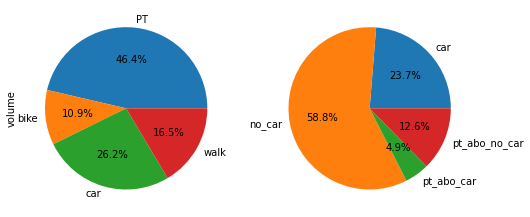

In [39]:
# Modal split total trips
pop_segments = np.round([
    (sm.zones['pop']*sm.zones['car_ownership']*(1-sm.zones['pt_subscriptions'])).sum(),
    (sm.zones['pop']*(1-sm.zones['car_ownership'])*(1-sm.zones['pt_subscriptions'])).sum(),
    (sm.zones['pop']*sm.zones['car_ownership']*sm.zones['pt_subscriptions']).sum(),
    (sm.zones['pop']*(1-sm.zones['car_ownership'])*sm.zones['pt_subscriptions']).sum()])
if show_plots:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    sm.los.groupby('route_type')['volume'].sum().plot.pie(autopct='%1.1f%%', ax=ax[0])
    ax[1] = plt.pie(pop_segments, autopct='%1.1f%%', labels=sm.segments)

In [40]:
# Number of trips per person
np.round(sm.los.groupby('route_type')[sm.segments].sum() /pop_segments, 2)

car  no_car  pt_abo_car  pt_abo_no_car
route_type                                         
PT          0.14    2.15        1.29           1.75
bike        0.05    0.36        0.04           1.15
car         3.32    0.00        2.17           0.00
walk        0.10    0.81        0.12           0.43

# Traffic assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [41]:
sm.car_los = sm.los.loc[sm.los['route_type'].isin(['car', 'bike'])].drop(columns=sm.segments, errors='irgnore')
sm.pt_los = sm.los.loc[~sm.los['route_type'].isin(['car', 'walk', 'bike'])].drop(columns=sm.segments, errors='irgnore')

In [42]:
# PT first
sm.segmented_pt_assignment(split_by=None, # 'route_type' to identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_abo_no_car: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.44s/it]


In [43]:
sm.links.loc[sm.links['load']!=0].sample()

trip_id                           a  \
index                                                 
link_22387  23414_700_2  node_de:11000:900060105::2   

                                     b  link_sequence  time   route_id  \
index                                                                    
link_22387  node_de:11000:900060104::6             29  60.0  23414_700   

           agency_id route_type    road_a     road_b  road_length  \
index                                                               
link_22387       796        bus  28196764  539267239      307.365   

                                                     geometry  \
index                                                           
link_22387  LINESTRING (13.34499 52.46132, 13.34515 52.461...   

                             road_node_list  road_link_list        load  
index                                                                    
link_22387  [28196764, 28196762, 539267239]  [13516, 13515]  188.120988

In [44]:
# Now cars
sm.segmented_car_assignment()

pt_abo_no_car: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [03:03<00:00, 45.91s/it]


In [45]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

a         b  length  validation_load  validation_share  \
index                                                                    
102608  204018205  81477621  78.578     19385.308004               1.0   

                                                 geometry   highway maxspeed  \
index                                                                          
102608  LINESTRING (13.33025 52.44530, 13.33014 52.445...  tertiary       50   

        validation_threshold    (car, car)  (no_car, car)  (pt_abo_car, car)  \
index                                                                          
102608                  True  17076.431528    2074.799936        2333.646622   

        (pt_abo_no_car, car)    (all, car)  
index                                       
102608           1567.492306  23052.370393

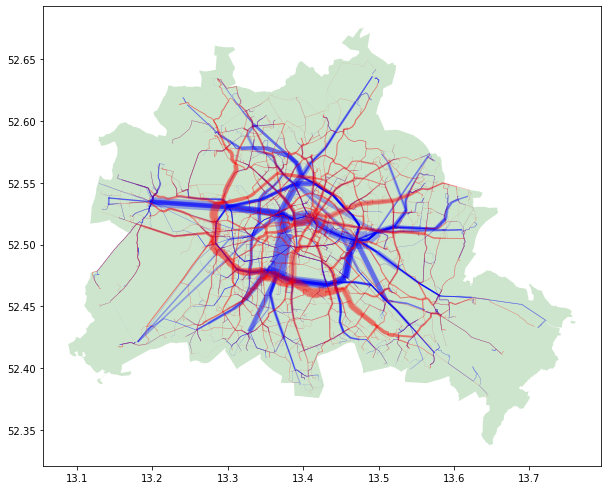

In [46]:
if show_plots:
    sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links, crs=sm.epsg)
    sm.road_links = gpd.GeoDataFrame(sm.road_links, crs=sm.epsg)
    scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / (35/2)

    fig, ax = plt.subplots(figsize = (10,10))
    sm.zones.plot(ax=ax, alpha=.2, color='green')
    sm.loaded_links.plot(ax=ax, alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler))
    sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))

    # sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    #     ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
    #         ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
    plt.savefig(output_path+scenario+'/network_load_pt_blue'+'_dpi300.png', dpi=300)

## Validation of road loads

In [47]:
traffic_validation = gpd.read_file(input_path + "traffic_validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=sm.epsg, inplace=True)

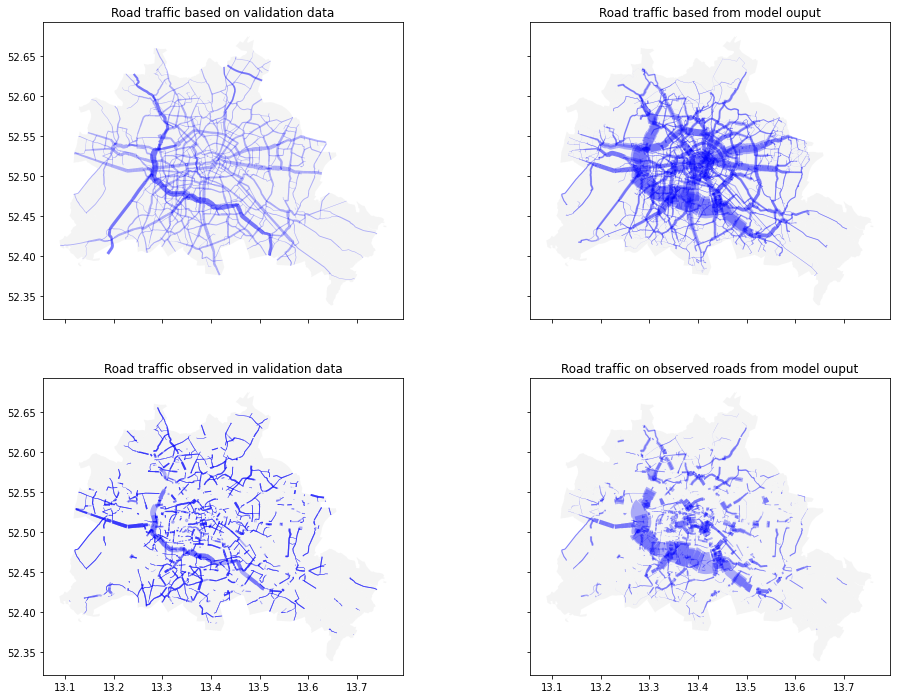

In [48]:
if show_plots:
    scaler_v = traffic_validation['dtvw_kfz'].max() / 7
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (16,12), sharex='all', sharey='all')
    sm.zones.plot(ax=ax.flat[0], alpha=.2, color='#cccccc')
    sm.zones.plot(ax=ax.flat[1], alpha=.2, color='#cccccc')
    sm.zones.plot(ax=ax.flat[2], alpha=.2, color='#cccccc')
    sm.zones.plot(ax=ax.flat[3], alpha=.2, color='#cccccc')

    traffic_validation.plot(ax=ax.flat[0], alpha=.3, color="blue", linewidth=list(traffic_validation['dtvw_kfz']/(scaler_v)))
    sm.road_links.plot(ax=ax.flat[1], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')]/scaler_v))
    ratio=sm.road_links[('all', 'car')][sm.road_links['validation_threshold']].sum()/sm.road_links['validation_load'][sm.road_links['validation_threshold']].sum()
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[2], alpha=.3, color='blue', linewidth=list(sm.road_links['validation_load'][sm.road_links['validation_threshold']]/scaler_v))
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[3], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']]/(scaler_v)))
    ax.flat[0].set_title('Road traffic based on validation data')
    ax.flat[1].set_title('Road traffic based from model ouput')
    ax.flat[2].set_title('Road traffic observed in validation data')
    ax.flat[3].set_title('Road traffic on observed roads from model ouput')
    
    plt.savefig(output_path+scenario+'/road_network_vs_validation'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+scenario+'/road_network_vs_validation'+'_dpi600.png', dpi=600)

network: 172  mio. validation: 251  mio. ratio n/v: 0.685


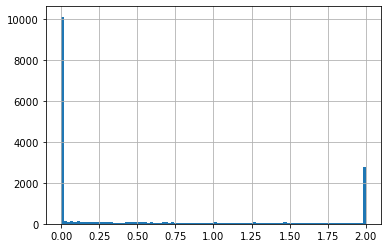

In [49]:
total_load_network = sum(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']])
total_load_validation = sum(sm.road_links['validation_load'][sm.road_links['validation_threshold']])
print('network:', np.round(int(total_load_network/1e6)), ' mio.', 
    'validation:',  np.round(int(total_load_validation/1e6)), ' mio.',
      'ratio n/v:', np.round(total_load_network/total_load_validation,3))

r_gdf = gpd.GeoDataFrame({
    'ratio': sm.road_links[('all', 'car')][sm.road_links['validation_threshold']]
        / sm.road_links['validation_load'][sm.road_links['validation_threshold']]
        * total_load_validation/total_load_network
    }, geometry=sm.road_links['geometry'][sm.road_links['validation_threshold']], crs=sm.epsg)

# ax0 = r_gdf['ratio'].hist(bins=100)
r_gdf['ratio_cut']=[x if x<2 else 2 for x in r_gdf['ratio']]
ax1 = r_gdf['ratio_cut'].hist(bins=100)


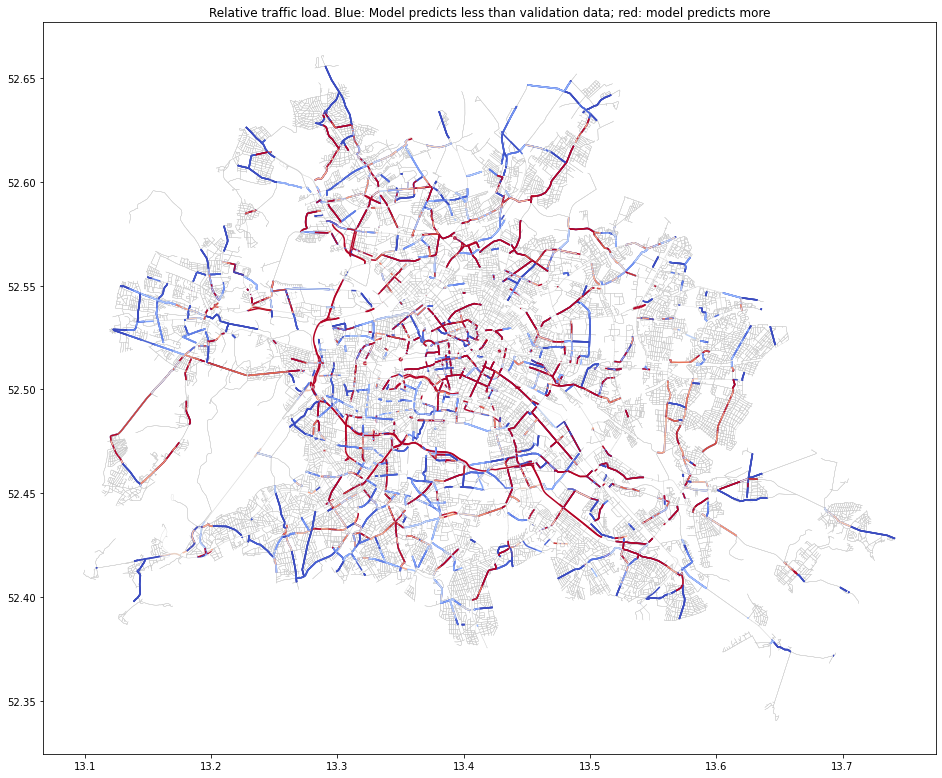

In [50]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    sm.road_links.plot(ax=ax, color="#cccccc", linewidth=0.25)
    r_gdf.plot(ax=ax, column='ratio_cut', cmap='coolwarm', legend=False)
    ax.set_title("Relative traffic load. Blue: Model predicts less than validation data; red: model predicts more")
    plt.savefig(output_path+scenario+'/road_network_vs_validation_ratio'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+scenario+'/road_network_vs_validation_ratio'+'_dpi600.png', dpi=600)

## Save model

In [51]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [52]:
sm.to_zippedpickles(model_path + scenario + '/four_steps', only_attributes=[
    'probabilities', 'utilities', 'car_los', 'pt_los', 'volumes', 'links', 'nodes', 'road_links'])

utilities: 100%|███████████████████████████████████████████████████████████████████████| 41/41 [00:43<00:00,  1.06s/it]
